In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import LSODA, solve_ivp
from numpy.linalg import solve, inv
import numba
import sys


sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward
from bachelor_funcs import analytic_green, get_first_dev, r_array
from ODE_schemes import A_matrix_regular

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

### Imposing the boundary condition:
$$\frac{\partial}{\partial r}(\Sigma r^{1/2})=0$$

In [4]:
N = 2001
x_i = 0.01
x_f = 2.1
x = np.linspace(x_i, x_f, N)
Δx = x[1] - x[0]
Δt = 0.004

A = A_matrix_regular(N + 2, 3, 1) / Δx
A[0] = 0
A[0, 0] = 1
A[-1] = 0
A[-1, -1] = 1

In [5]:
def new_bound_ghost(t, Σ):
    inner = Σ * x**(1/2)
    ghost_1 = np.array([inner[1]])
    ghost_2 = np.array([inner[-2]])

    inner_ghost = np.concatenate((ghost_1, inner, ghost_2))
    x_ghost = np.concatenate((np.array([x[0] - Δx]), x, np.array([x[-1] + Δx])))

    outer_ghost = x_ghost**(1/2) * (A @ inner_ghost) 
    sec_dev = 3 / x_ghost * (A @ outer_ghost)

    return sec_dev[1: -1]

In [6]:
times = np.array([0.006, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]) / 12

Σ_initial = analytic_green(x, 0.006)
sol = solve_ivp(new_bound_ghost, [times[0], times[-1]], y0 = Σ_initial, t_eval = times, method = 'LSODA')

[Text(0.5, 1.0, 'Analytical solution'),
 Text(0, 0.5, 'πΣ(r,τ)'),
 Text(0.5, 0, 'r')]

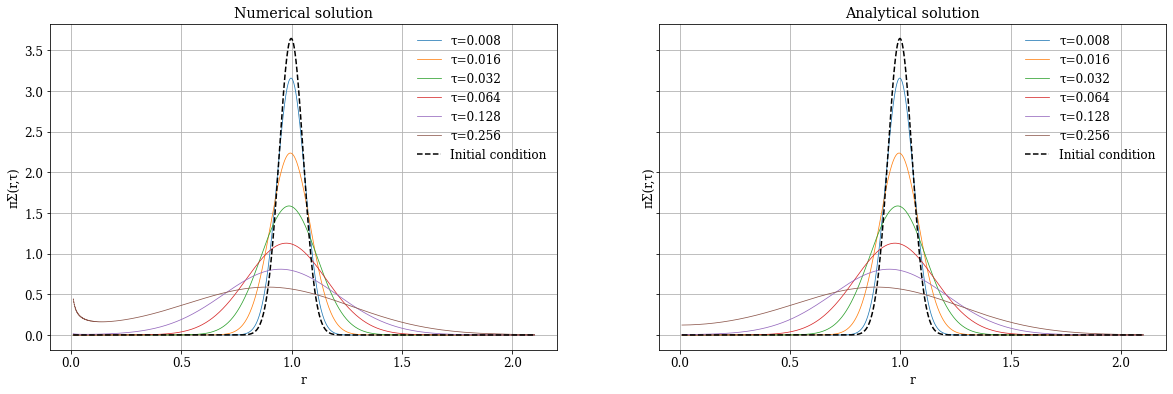

In [8]:
fig, axs = plt.subplots(1,2, figsize=(20,6), sharey=True)
axs[0].grid()

#Plotting numerical solution
for t in times[1:]:
    axs[0].plot(x, np.pi * sol.y[:, sol.t == t], label=f'τ={t*12}', lw=0.75)
axs[0].plot(x, np.pi * Σ_initial, label='Initial condition', c='black', ls='--')

axs[0].legend(frameon = False)
axs[0].set(title='Numerical solution', ylabel='πΣ(r,τ)', xlabel='r')

#Plotting analytical solution
for t in times[1:]:
    axs[1].plot(x, np.pi * analytic_green(x, t*12), label=f'τ={t*12}', lw=0.75)
axs[1].grid()

axs[1].plot(x, np.pi* Σ_initial, label='Initial condition', c='black', ls='--')
axs[1].legend(frameon = False)
axs[1].set(title='Analytical solution', ylabel='πΣ(r,τ)', xlabel='r')